# Experiment 1

In [1]:
import functools
import pathlib

import pandas as pd
import numpy as np
import pickle
from scipy import stats
import seaborn as sns

from videoannotator import config as cfg, experiments, data

In [2]:
sns.set_context('notebook')

## helpers

In [5]:
@dataclass(frozen=True)
class Beat:
    champ: experiments.Metric
    chall: experiments.Metric
        
    @property
    def better(self):
        if self.champ is None:
            return True
        return self.chall.mean > self.champ.mean
    
    @property
    def sig(self):
        if self.better:
            if self.champ is None: return True
            return (self.chall.mean - self.chall.std) > (self.champ.mean + self.champ.std)
        return False
    
    @property
    def lift(self):
        if self.champ and self.chall:
            return self.chall.mean / self.champ.mean - 1
        
    @property
    def gain(self):
        if self.champ and self.chall:
            return self.chall.mean - self.champ.mean
    
    def __repr__(self):
        return f"Beat(better={self.better}, sig={self.sig})"

def at(l, cnt):
    d = res[l]
    cmp = {
        method: er
        for (n, method, scoring), er in d['cmp'].items()
        if n == cnt and scoring == 'average_precision'
    }
    va = [
        x
        for x in d['checkpoints']
        if len(x.lds_train) <= (cnt + 10)  # allow for up to n + 10
    ]
    va_ap = max(va, key=lambda x: x.average_precision.mean).average_precision if len(va) > 0 else None
    return dict(
        label=l,
        baseline=d['baseline_agg'],
        zs=d['zero_shot'].average_precision,
        va_cnt=len(va[-1].lds_train) if len(va) > 0 else None,
        va=va_ap,
        cmp_zs=cmp['zero-shot'].average_precision if 'zero-shot' in cmp else None,
        cmp_random=cmp['random'].average_precision if 'random' in cmp else None,
        cmp_comb=cmp['zero-shot-50-random-50'].average_precision if 'zero-shot-50-random-50' in cmp else None,
    )

def beat_cols(champ_, chall_):
    return [
        Beat(champ=champ, chall=chall)
        for champ, chall in zip(champ_, chall_)
    ]

def analyze(cnt):
    df = pd.DataFrame(map(lambda l: at(l, cnt=cnt), res.keys()))
    n = len(df)
    df = df[df.va_cnt.notnull()]
    if len(df) < n:
        print(f'lost {n - len(df)} / {n} for cnt= {cnt}')
    return df.assign(
        va_beats_bl=beat_cols(df.baseline, df.va),
        va_beats_zs=beat_cols(df.zs, df.va),
        va_beats_cmp_zs=beat_cols(df.cmp_zs, df.va),
        va_beats_cmp_rand=beat_cols(df.cmp_random, df.va),
        va_beats_cmp_comb=beat_cols(df.cmp_comb, df.va),
        cnt=cnt,
    )

def agg(df, sig):
    df = df.groupby('cnt').apply(
        lambda rows: pd.Series(dict(
            beats_baseline=rows.va_beats_bl.apply(lambda x: x.better).mean(),
            beats_baseline_sig=rows.va_beats_bl.apply(lambda x: x.sig).mean(),
            beats_zs=rows.va_beats_zs.apply(lambda x: x.better).mean(),
            beats_zs_sig=rows.va_beats_zs.apply(lambda x: x.sig).mean(),
            beats_cmp_rand=rows.va_beats_cmp_rand.apply(lambda x: x.better).mean(),
            beats_cmp_rand_sig=rows.va_beats_cmp_rand.apply(lambda x: x.sig).mean(),
            beats_cmp_zs=rows.va_beats_cmp_zs.apply(lambda x: x.better).mean(),
            beats_cmp_zs_sig=rows.va_beats_cmp_zs.apply(lambda x: x.sig).mean(),
            beats_cmp_comb=rows.va_beats_cmp_comb.apply(lambda x: x.better).mean(),
            beats_cmp_comb_sig=rows.va_beats_cmp_comb.apply(lambda x: x.sig).mean(),
        ))
    )
    cols = [c for c in df.columns if ((sig and '_sig' in c) or (not sig and '_sig' not in c))]
    return df[cols]


def _get_diff(df, c):
    return [
        x.chall.mean - x.champ.mean
        for x in df[c]
        if x.lift
    ]

def f(df, col=None):
    rows = []

    cols = [c for c in d.columns if 'va_beats_' in c]
    cs = cols if col is None else [col]
    for c in cs:
        gain = _get_diff(df, c)
        if len(gain) == 0:
            x = 'nan'
            continue
        x = np.percentile(gain, q=50)
        rows.append(dict(c=c, val=x))

    if col is None:
        return pd.DataFrame(rows).set_index('c')
    else:
        return pd.Series([x['val'] for x in rows], index=[x['c'] for x in rows])
    
def coverage(df):
    cs = ['va_beats_cmp_zs', 'va_beats_cmp_rand', 'va_beats_cmp_comb']
    return pd.Series([
        sum(
            x.champ is not None
            for x in df[c]
        ) / len(cfg.LABELS)
        for c in cs
    ], index=cs)


def lift(df, q, col=None):
    cs = [c for c in cols if 'bl' not in c] if col is None else [col]
    return pd.Series([
        np.percentile(_get_diff(df, c), q=q)
        for c in cs
    ], index=cs)

def plot(res, label):
    try:
        pd.DataFrame(
            dict(
                n=n,
                method=method,
                r=r.average_precision.mean,
            )
            for (n, method, scoring), r in res[label]['cmp'].items()
            if scoring == 'average_precision'
        ).pivot_table(index='n', columns='method', values='r').plot()
    except Exception as e:
        print(f'failed {label} error: {e}')
    pd.DataFrame(
        dict(n=len(er.lds_train), ap=er.average_precision.mean)
        for er in res[label]['checkpoints']
    ).set_index('n').ap.plot()
    plt.hlines(
        res[label]['baseline_agg'].mean,
        xmin=0,
        xmax=1000,
        colors='r',
        linestyles='dotted',
    )
    plt.hlines(
        res[label]['zero_shot'].average_precision.mean,
        xmin=0,
        xmax=1000,
        colors='k',
        linestyles='dotted',
    )
    plt.ylim([0, 1])
    plt.title(label)
    plt.show()
    
@functools.lru_cache()
def get_cmp_data_scores(l, which):
    cmp = data.CompDataset(l, frozenset())
    fn = getattr(cmp, f'get_ordered_dataset_{which}')
    od = fn(keys_to_remove=frozenset())
    return {n: od.get_n(n).lds.data_score for n in ns}

@functools.lru_cache()
def get_cmp_comb_data_scores(l):
    cmp = data.CompDataset(l, frozenset())
    return {
        n: (cmp.get_ordered_dataset_random().get_n(n // 2) + cmp.get_ordered_dataset_zero_shot().get_n(n // 2)).lds.data_score
        for n in ns
    }

@functools.lru_cache()
def get_va_data_scores(l):
    ldss = data.get_labeled_dataset_checkpoints(l)
    vals = dict()
    d = 10
    for lds in ldss:
        if len(lds) >= d:
            vals[(len(lds) // d) * d] = lds.data_score
    return [
        dict(
            label=l,
            n=k,
            method='Video Annotator (VA)',
            data_score=v,
        )
        for k, v in vals.items()
    ]

group_lookup = {
    v: k
    for k, vs in cfg.LABEL_GROUPS.items()
    for v in vs
}

## run experiment 1

In [6]:
# this takes ~20 mins on a machine with 64 CPUs and 64GB RAM
path_results_pkl = 'exp1_results.pkl'
if not pathlib.Path(path_results_pkl).exists():
    exp = experiments.Experiment()
    res = exp.experiment_active_learning_batch(labels=cfg.LABELS)
    pickle.dump(res, open(path_results_pkl, 'wb'))
else:
    res = pickle.load(open(path_results_pkl, 'rb'))

In [7]:
# organize the data for analysis
df = pd.concat([analyze(n) for n in (25, 50, 100, 500, 1000)])
d = df.assign(group=df.label.map(group_lookup))

WARNING 2024-02-09 05:22:21,498 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,498 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,499 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,504 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,504 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,505 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,505 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 05:22:21,506 experiments.py(32) Metric has NaN values: (0.3333333333

lost 23 / 56 for cnt= 25
lost 7 / 56 for cnt= 50
lost 4 / 56 for cnt= 100


## Fig 7

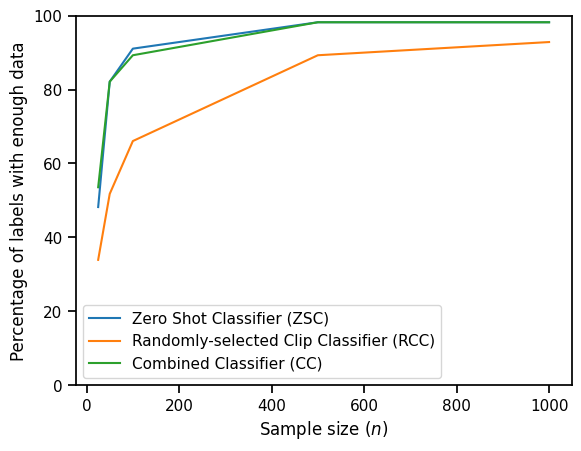

In [8]:
cov = d.groupby('cnt').apply(coverage) * 100
cov.rename(columns=dict(
    va_beats_cmp_zs='Zero Shot Classifier (ZSC)',
    va_beats_cmp_rand='Randomly-selected Clip Classifier (RCC)',
    va_beats_cmp_comb='Combined Classifier (CC)',
)).plot()
plt.xlabel('Sample size ($n$)')
_ = plt.ylabel('Percentage of labels with enough data')
_ = plt.ylim([0, 100])

## Fig 8

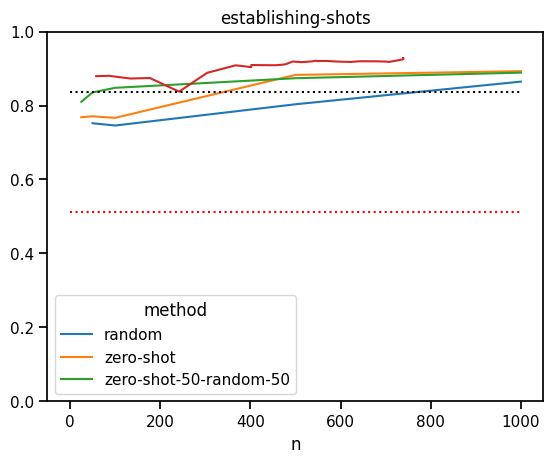

In [9]:
label = 'establishing-shots'
plot(res, label)

## Fig 9

WARNING 2024-02-09 05:22:28,610 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:28,670 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2024-02-09 05:22:28,675 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 05:22:28,685 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:28,685 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 05:22:28,820 experiments.py(32) Metric has NaN values: (0.1, nan, 0.1111111111111111, 0.15384615384615385, 0.2222222222222222)
WARNING 2024-02-09 05:22:28,826 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 05:22:28,835 experiments.py(32) Metric 

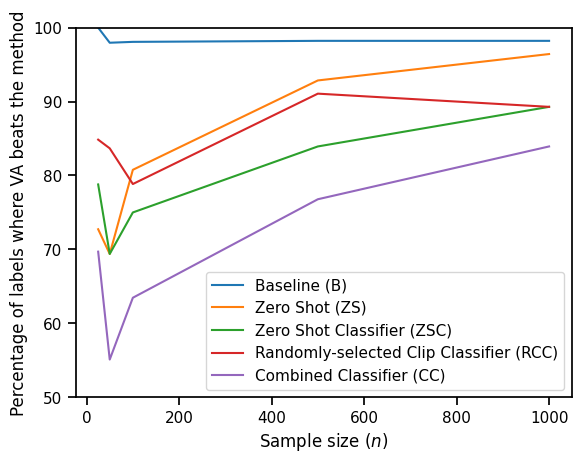

In [10]:
q = (df.groupby('cnt').apply(lambda xs: pd.Series({
    c: sum(
        (x.lift and x.lift >= 0) or (x.chall is not None and x.champ is None)
        for x in xs[c]
    ) / sum(
        x.chall is not None
        for x in xs[c]
    )
    for c in df.columns if '_beats_' in c
})) * 100)
q.rename(columns={
    'va_beats_bl': 'Baseline (B)',
    'va_beats_zs': 'Zero Shot (ZS)',
    'va_beats_cmp_zs': 'Zero Shot Classifier (ZSC)',
    'va_beats_cmp_rand': 'Randomly-selected Clip Classifier (RCC)',
    'va_beats_cmp_comb': 'Combined Classifier (CC)',
}).plot()
plt.ylim([50, 100])
plt.xlabel('Sample size ($n$)')
_ = plt.ylabel('Percentage of labels where VA beats the method')

## Table 2

In [11]:
(d[d.cnt != 500].groupby(['cnt', 'group']).apply(lambda x: f(x, col='va_beats_cmp_comb')).unstack().T * 100).round(1).droplevel(0) #.to_latex()

WARNING 2024-02-09 05:22:31,718 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:31,727 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


cnt,25,50,100,1000
group,,,,
emotions,-6.0,-5.1,-4.2,3.7
events_actions,6.9,5.5,5.7,3.8
focus,1.2,-1.2,-0.4,1.8
genres,6.6,5.3,3.9,1.8
motion,31.5,1.2,5.6,3.0
sensitivities,0.5,-0.3,0.8,3.4
shot_types,1.2,0.6,0.5,2.3
time_location,4.6,-8.5,1.3,1.4


In [12]:
# last row in table 2
(d.groupby(['cnt']).apply(lambda x: f(x, col='va_beats_cmp_comb')).unstack().T * 100).round(1)

WARNING 2024-02-09 05:22:37,380 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:22:37,381 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
WARNING 2024-02-09 05:22:37,387 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)


                   cnt 
va_beats_cmp_comb  25      1.2
                   50      0.4
                   100     1.5
                   500     1.7
                   1000    2.9
dtype: float64

## Fig 10

In [13]:
ns = (25, 50, 100, 500, 1_000)
df_ds = pd.concat([
    pd.DataFrame(
        dict(
            n=n,
            method='Upper bound',
            data_score=min(n / 200, 1),
        )
        for n in ns
    ),
    pd.DataFrame(
        dict(n=n, method='Zero Shot Classifier (ZSC)', data_score=get_cmp_data_scores(l=l, which='zero_shot')[n])
        for n in ns
        for l in cfg.LABELS
    ),
    pd.DataFrame(
        dict(n=n, method='Randomly-selected Clip Classifier (RCC)', data_score=get_cmp_data_scores(l=l, which='random')[n])
        for n in ns
        for l in cfg.LABELS
    ),
    pd.DataFrame(
        dict(n=n, method='Combined Classifier (CC)', data_score=get_cmp_comb_data_scores(l)[n])
        for n in ns
        for l in cfg.LABELS
    ),
    pd.DataFrame(
        row
        for l in cfg.LABELS
        for row in get_va_data_scores(l)
    )
])

WARNING 2024-02-09 05:22:47,667 data.py(64) LabeledDataset(label=shutter-shot, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-09 05:22:47,672 data.py(64) LabeledDataset(label=shutter-shot, cnt=50, pos_cnt=0, neg_cnt=50, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-09 05:22:47,676 data.py(64) LabeledDataset(label=shutter-shot, cnt=100, pos_cnt=0, neg_cnt=100, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-09 05:22:47,680 data.py(64) LabeledDataset(label=shutter-shot, cnt=500, pos_cnt=0, neg_cnt=500, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-09 05:22:47,684 data.py(64) LabeledDataset(label=shutter-shot, cnt=1000, pos_cnt=0, neg_cnt=1000, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-09 05:22:47,761 data.py(64) LabeledDataset(label=timelapse, cnt=25, pos_cnt=0, neg_cnt=25, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-09 05:22:47,764 data.py(64) LabeledDataset(label=timela

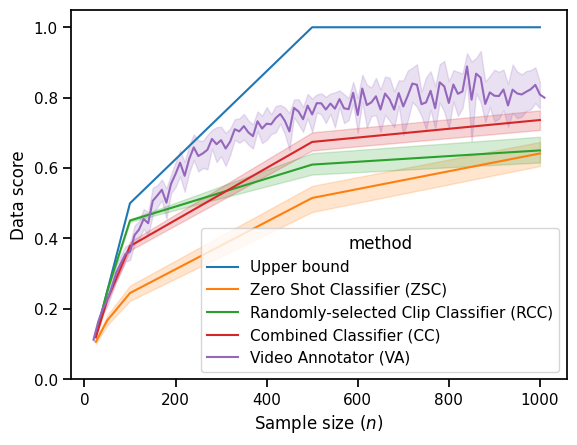

In [14]:
sns.lineplot(data=df_ds, x='n', y='data_score', hue='method')
plt.ylim([0, 1.05])
plt.ylabel('Data score')
_ = plt.xlabel('Sample size ($n$)')

## store values needed for experiment 2

### store last and best values per label

In [15]:
ap_va_best = {
    l: dict(
        last=res[l]['checkpoints'][-1].average_precision.mean,
        best=max(
            res[l]['checkpoints'],
            key=lambda x: (
                x.average_precision.mean
                if x.average_precision.mean is not None
                else -1
            ),
        ).average_precision.mean
    )
    for l in cfg.LABELS
}
# this object is used for experiment 2
pickle.dump(ap_va_best, open('ap_va_best.pkl', 'wb'))

WARNING 2024-02-09 05:23:03,979 experiments.py(32) Metric has NaN values: (0.2, nan, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333)
WARNING 2024-02-09 05:23:03,980 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:23:03,981 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:23:03,981 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:23:03,982 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 05:23:03,982 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 05:23:03,983 experiments.py(32) Metric has NaN values: (0.25, nan, 0.5, 0.3333333333333333, 0.6666666666666666)
WARNING 2024-02-09 05:23:03,983 experiments.py(32) Metric has NaN values

### per-label AP gain at n=1,000
for labels with max(n) < 1000, we just take the last value

In [16]:
d1000 = d[d.cnt == 1_000]
q = d1000[['label']].assign(gain=d[d.cnt == 1000]['va_beats_cmp_comb'].apply(lambda x: x.gain)).set_index('label').gain.to_dict()
pickle.dump(q, open('exp1_gain.pkl', 'wb'))

WARNING 2024-02-09 05:23:05,783 experiments.py(32) Metric has NaN values: (0.3333333333333333, nan, 0.5, 0.4, 0.6666666666666666)
WARNING 2024-02-09 05:23:05,788 experiments.py(32) Metric has NaN values: (0.5, nan, 1.0, 0.6666666666666666, 0.6666666666666666)
